# Location Analysis

In [1]:
import pandas as pd
import utils
%load_ext autoreload
%autoreload 2

# Create LocationUtils instance and read in data
location_util = utils.LocationUtils()

df = pd.read_json("rttdiff-server-dist.jsonl", lines=True)

In [2]:
# Read in the whole logfile to get the other metadata (namely the user location)

logfile = pd.read_json("050223-w41-logFile.jsonl", lines=True)

logfile = logfile.dropna(axis=0, subset='LocationUser')
logfile = logfile.dropna(axis=1)

In [3]:
# Add LocationUser and LocationVPN into the dataframe

def get_loc_user(logfile: pd.DataFrame, uuid: str, column_val: str):
    tmp = logfile.loc[logfile['UUID'] == uuid]
    return tmp[column_val].values[0]

df['location_user'] = df['uuid'].apply(lambda uuid: get_loc_user(logfile, uuid, 'LocationUser'))
df['location_vpn'] = df['uuid'].apply(lambda uuid: get_loc_user(logfile, uuid, 'LocationVPN'))

The following uses the IP locator API to calculate the distance from the IP address to the BBB server. There is a rate limit on the API so this can take a while to run, and should only really be run once. The results are then written to a file.

In [4]:
# df = location_util.apply_distance_from_server_to_dataframe(df)
# df.to_json("rttdiff-server-dist-new.jsonl", orient='records', lines=True)

In [5]:
import matplotlib.pyplot as plt

def plot_dist_vs_rtt(direct, vpn):
    """Plots the distance from server vs the rttd"""

    _, ax = plt.subplots()

    direct.plot(kind="scatter", x="distance_from_server", y="rttd", ax=ax, color="blue", label="Direct")
    vpn.plot(kind="scatter", x="distance_from_server", y="rttd", ax=ax, color="red", label="VPN")

    ax.set_xlabel("Distance From Server (miles)")
    ax.set_ylabel("RTT Difference")
    
    ax.legend()

    plt.show()
    
    
def plot_df_dist_vs_rtt(direct, vpn):
    """
    For VPN instances, it plots the distance between user and VPN server vs rttd
    For direct instances, it plots the distance from server vs rttd
    """

    _, ax = plt.subplots()

    direct.plot(kind="scatter", x="distance_from_server", y="rttd", ax=ax, color="blue", label="Direct")
    vpn.plot(kind="scatter", x="dist_bet_user_vpn", y="rttd", ax=ax, color="red", label="VPN")

    ax.set_xlabel("Distance From Server (miles)")
    ax.set_ylabel("RTT Difference")
    
    ax.legend()

    plt.show()



In [6]:
# Connections with rttd under 50 ms

sub_50 = df[df['rttd'] <= 50]
direct_sub_50 = sub_50[sub_50['exptype'] == 'direct']
vpn_sub_50 = sub_50[sub_50['exptype'] == 'vpn']

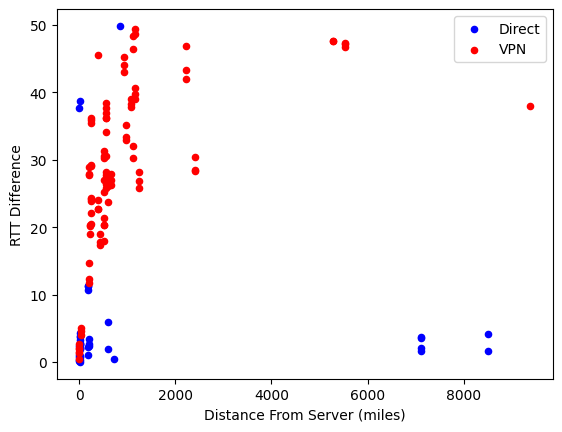

In [7]:
plot_dist_vs_rtt(direct_sub_50, vpn_sub_50)

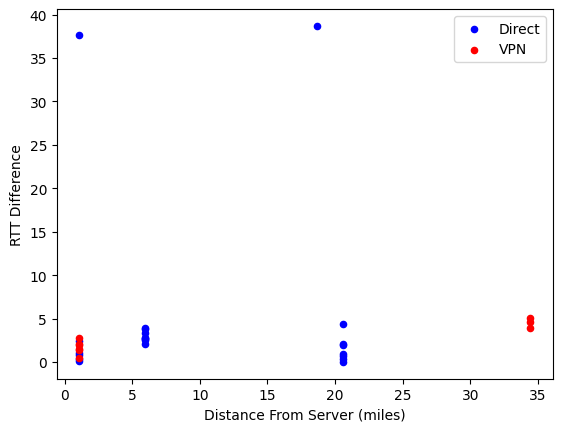

In [8]:
close_threshold = 50 # in miles

close_direct = direct_sub_50[direct_sub_50["distance_from_server"] <= close_threshold]
close_vpn = vpn_sub_50[vpn_sub_50["distance_from_server"] <= close_threshold]

plot_dist_vs_rtt(close_direct, close_vpn)


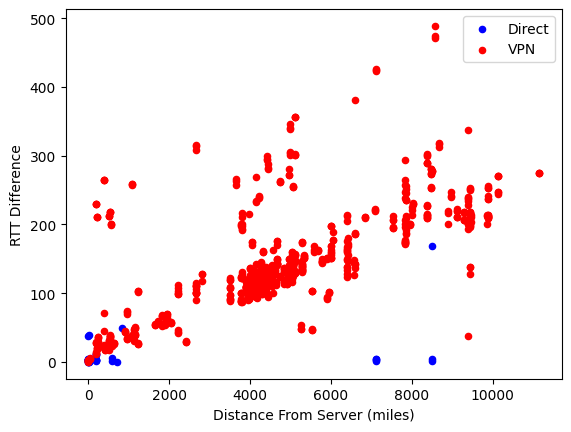

In [9]:
direct_full = df[df['exptype'] == 'direct']
vpn_full = df[df['exptype'] == 'vpn']

# There are two outlier datapoints for direct connections - not sure what happened there
direct_full = direct_full[direct_full['rttd'] < 2000]

plot_dist_vs_rtt(direct_full, vpn_full)



# Analysis using distance between user and VPN server

The following uses the Nominatim API to find location data. This API also has a rate limit throttling, so it would be great if it were only ran once (although for the initial data collection there weren't many unique user locations so this was pretty quick).

In [10]:
# Could use the vpn subset instead of the entire dataframe to speed up the process.
# I figured it could be helpful to have the direct connection data to double check
# with the ipaddr that the user is actually doing a direct connection.

df = location_util.apply_coordinates_of_user_loc(df)


DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CITY: ann arbor
DUPLICATE CI

In [18]:
# This cell is used to double check that the locations are correct - most errors occurred due to spelling errors by the user


location_input = df['location_user'] == "Ann Arbor"

df.loc[location_input, 'user_coordinates'] = df.loc[location_input, 'user_coordinates'].apply(lambda _: (42.2681569, -83.7312291))
df.loc[location_input, 'manual_check'] = df.loc[location_input, 'manual_check'].apply(lambda _: False)


vpn = df[df['exptype'] == 'vpn']
manual_check = vpn[vpn['manual_check'] == True]

manual_check
# print(vpn[chicago_ord])

,uuid,ipaddr,exptype,mss,type,rttd,distance_from_server,location_user,location_vpn,user_coordinates,manual_check


This code uses the IP Address location along with the user_coordinates to calculate the distance between the user and VPN server. This could also take a while to run, but if the IP addresses are still cached from earlier, it should be fairly quick.

In [21]:
# This really only applies to VPN connections

vpn = df[df['exptype'] == 'vpn']

vpn = location_util.apply_distance_bet_user_server(vpn)
vpn.to_json('vpn-rttdiff-server-dist-new.jsonl', orient='records', lines=True)

DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 68.62.17.5
DUPLICATE IP ADDRESS: 216.131.118.7
DUPLICATE IP ADDRESS: 216.131.118.7
DUPLICATE IP ADDRESS: 216.131.118.7
DUPLICATE IP ADDRESS: 98.159.224.200
DUPLICATE IP ADDRESS: 64.64.116.157
DUPLICATE IP ADDRESS: 98.159.224.201
DUPLICATE IP ADDRESS: 216.131.120.61
DUPLICATE IP ADDRESS: 216.131.120.61
DUPLICATE IP ADDRESS: 173.195.15.128
DUPLICATE IP ADDRESS: 216.131.84.68
DUPLICATE IP ADDRESS: 216.131.120.61
DUPLICATE IP ADDRESS: 216.131.84.68
DUPLICATE IP ADDRESS: 173.195.15.128
DUPLICATE IP ADDRESS: 173.255.172.145
DUPLICATE IP ADDRESS: 216.131.84.68
DUPLICATE IP ADDRESS: 216.73.162.190
DUPLICATE IP ADDRESS: 173.195.15.128
DUPLICATE IP ADDRESS: 216.151.184.118
DUPLICATE IP ADDRESS: 173.245.203.122
DUPLICATE IP ADDRESS: 173.245.203.122
DUPLICATE IP ADDRESS: 205.185.209.135
DUPLICATE IP ADDRESS: 216.7

/Users/samkorman/src/zerotrace-eval/generate graph/utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_bet_user_vpn'] = df.apply(lambda row: self.get_dist_bet_coords(row.ipaddr, row.user_coordinates), axis=1)


In [22]:

def plot_user_dist_vs_rtt(vpn):

    fig, ax = plt.subplots()

    # direct.plot(kind="scatter", x="distance_from_server", y="rttd", ax=ax, color="blue", label="Direct")
    vpn.plot(kind="scatter", x="dist_bet_user_vpn", y="rttd", ax=ax, color="red", label="VPN")

    ax.set_xlabel("Distance Between User and VPN Server (miles)")
    ax.set_ylabel("RTT Difference")
    
    ax.legend()

    plt.show()

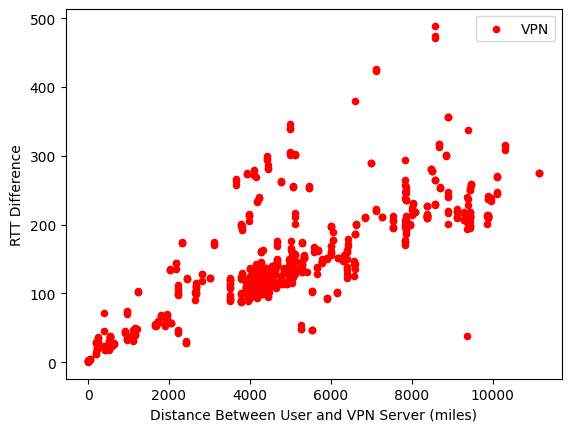

In [23]:
plot_user_dist_vs_rtt(vpn)

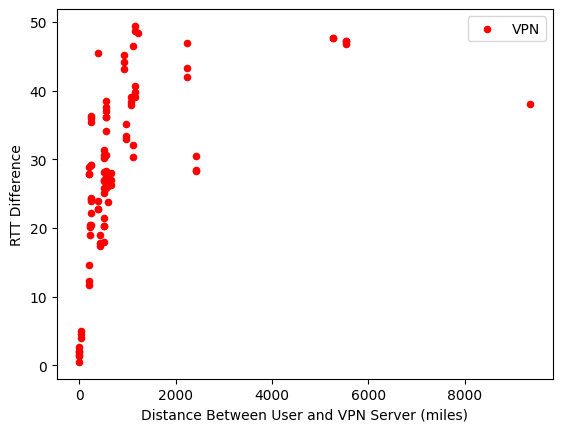

In [24]:
close_vpn = vpn[vpn['rttd'] <= 50]

plot_user_dist_vs_rtt(close_vpn)

In [28]:
percentage = 1 - len(close_vpn[close_vpn['dist_bet_user_vpn'] > 2000]) / len(close_vpn)

print("Percent VPN with rttd under 50ms and distance between user and VPN under 2,000 miles:", percentage * 100)

Percent VPN with rttd under 50ms and distance between user and VPN under 2,000 miles: 87.2340425531915


In [29]:
def color_diff_types(vpn):
    """Color each different datapoint by the result of the decision tree"""
    
    _, ax = plt.subplots()
    cm = plt.get_cmap('Dark2')
    
    for i, data_type in enumerate(vpn.type.unique()):
        subdf = vpn[vpn['type'] == data_type]
        
        subdf.plot(kind="scatter", x="dist_bet_user_vpn", y="rttd", ax=ax, color=cm(i), label=data_type)
    

    ax.set_xlabel("Distance Between User and VPN Server (miles)")
    ax.set_ylabel("RTT Difference")
    
    ax.legend()

    plt.show()

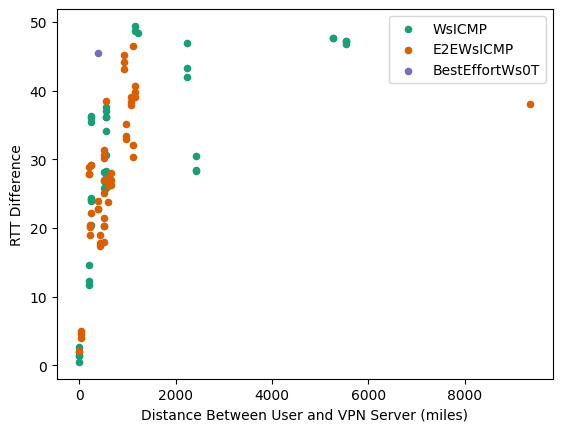

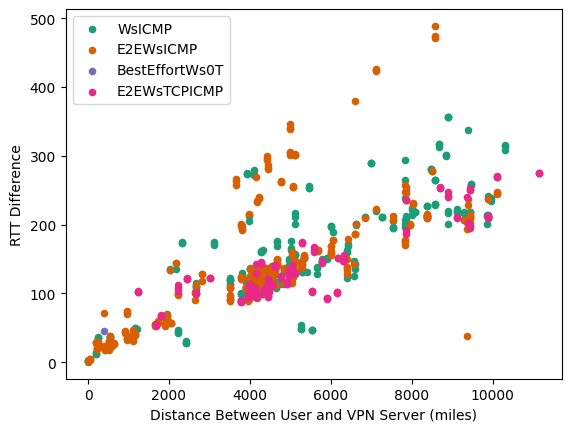

In [30]:
color_diff_types(close_vpn)
color_diff_types(vpn)